In [13]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib.dates as mdates
import pickle
from scipy import stats
from pandas.tools.plotting import autocorrelation_plot
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.api import qqplot
from sklearn import metrics
import statsmodels.api as sm
from datetime import datetime,timedelta

## ARMA task

### Load dataset and change the format of datetime

In [14]:
def parser(x):
    return pd.datetime.strptime(x,'%d/%m/%y %H')

dataset = pd.read_csv('BATADAL_dataset_train.csv',index_col=0,header=0,parse_dates=[0],date_parser=parser)
del dataset.index.name

# dataset.index.values

8761
Index(['L_T1', 'L_T2', 'L_T3', 'L_T4', 'L_T5', 'L_T6', 'L_T7', 'F_PU1',
       'S_PU1', 'F_PU2', 'S_PU2', 'F_PU3', 'S_PU3', 'F_PU4', 'S_PU4', 'F_PU5',
       'S_PU5', 'F_PU6', 'S_PU6', 'F_PU7', 'S_PU7', 'F_PU8', 'S_PU8', 'F_PU9',
       'S_PU9', 'F_PU10', 'S_PU10', 'F_PU11', 'S_PU11', 'F_V2', 'S_V2',
       'P_J280', 'P_J269', 'P_J300', 'P_J256', 'P_J289', 'P_J415', 'P_J302',
       'P_J306', 'P_J307', 'P_J317', 'P_J14', 'P_J422', 'ATT_FLAG'],
      dtype='object')


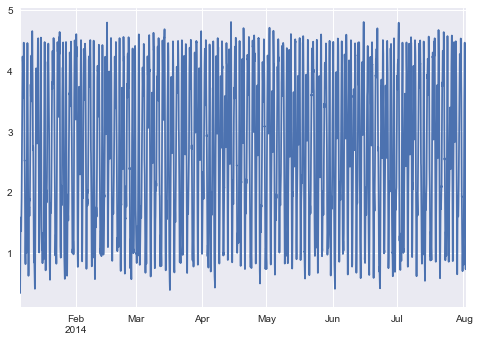

In [15]:
# see some basic data information
print(len(dataset))
print(dataset.columns)
plt.clf()
dataset['L_T1'][0:5000].plot()
plt.show()

### correlation matrix -- see if there's any correalation between sensors

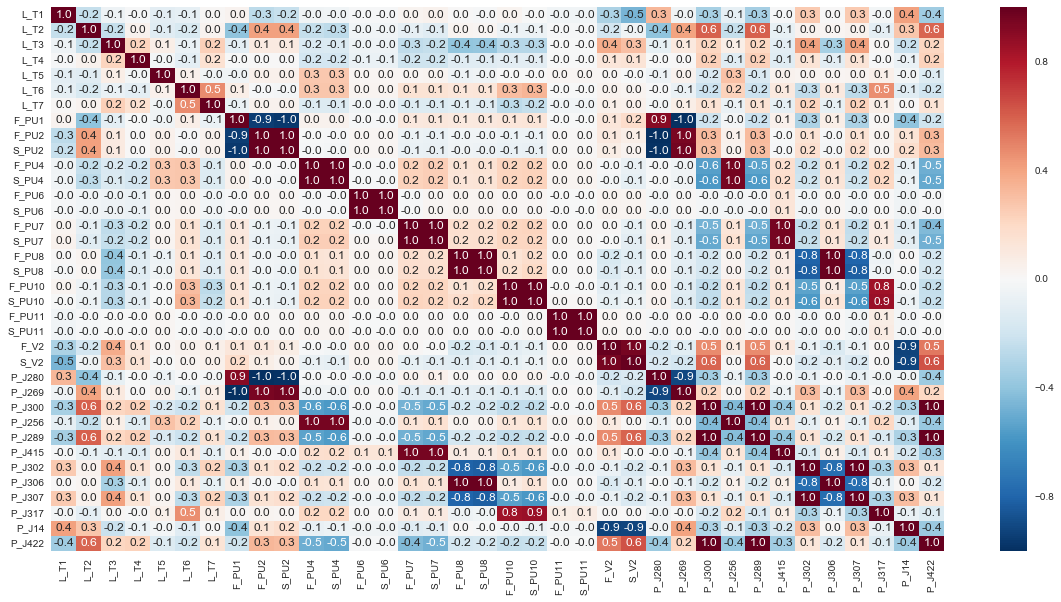

In [16]:
df_corr = dataset.corr()
# print(df_corr,'\n\n')
df_corr.fillna(99999,inplace =True)
dataset_2 = dataset.drop(df_corr.index[df_corr['L_T1']==99999],axis = 1)
df_corr = dataset_2.corr()
# print(dataset_2.head())

plt.clf()
plt.figure(figsize=(20,10))
sns.heatmap(df_corr, annot=True, fmt=".1f")
plt.show()

### Autocorrelation and partial autocorrelation
#### Method one: using rules to select p and q
Rules for deciding the parameter p and q
- Rule 1: If the ACF shows exponential decay, the PACF has a spike at lag 1, and no correlation for other lags, then use one autoregressive (p)parameter
- Rule 2: If the ACF shows a sine-wave shape pattern or a set of exponential decays, the PACF has spikes at lags 1 and 2, and no correlation for other lags, the use two autoregressive (p) parameters
- Rule 3: If the ACF has a spike at lag 1, no correlation for other lags, and the PACF damps out exponentially, then use one moving average (q) parameter.
- Rule 4: If the ACF has spikes at lags 1 and 2, no correlation for other lags, and the PACF has a sine-wave shape pattern or a set of exponential decays, then use two moving average (q) parameter.
- Rule 5: If the ACF shows exponential decay starting at lag 1, and the PACF shows exponential decay starting at lag 1, then use one autoregressive (p) and one moving average (q) parameter.

p, q can be set as 2,1

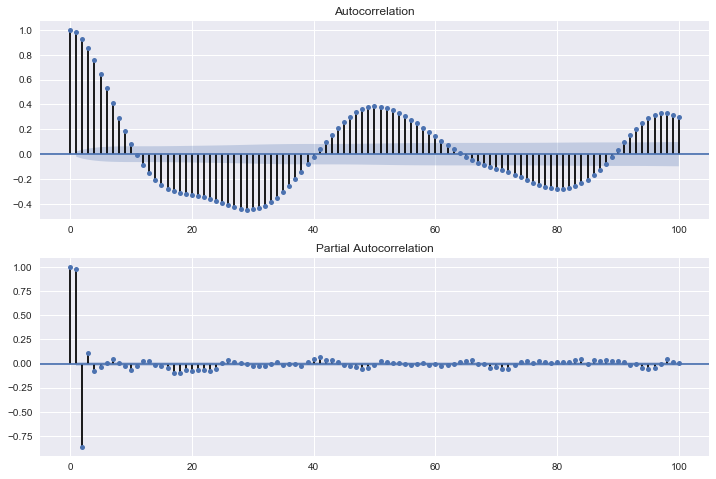

In [11]:
dataset_LT1 = dataset['L_T1']

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(dataset_LT1.values.squeeze(), lags=100, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(dataset_LT1, lags=100, ax=ax2)
plt.show()

#### Another popular test for serial correlation is the Durbin-Watson statistic. 
#### The DW statistic will lie in the 0-4 range, with a value near two indicating no first-order serial correlation. Positive serial correlation is associated with DW values below 2 and negative serial correlation with DW values above 2.

The value of Durbin-Watson statistic is close to 2 if the errors are uncorrelated. In our example, it is 0.00643. That means that there is a strong evidence that the variable open has high autocorrelation.

In [6]:
sm.stats.durbin_watson(dataset_LT1)

0.006432171620535719

#### Method two : loop over p and q and compare AIC to get the best model

In [144]:
arma_models = []
sensors = ['L_T1', 'L_T2', 'L_T3', 'L_T4', 'L_T5', 'L_T6', 'L_T7']

p_values = range(1,6)
d_values = range(0,3)
q_values = range(0, 3)
Best_models = {}
for sensor in sensors:
        dataset_test = dataset[sensor]
        Ps = []
        Ds = []
        Qs = []
        resids = []
        dws = []
        AICs = []
        print("sensor:", sensor)
        for p in p_values:
            for d in d_values:
                for q in q_values:
                    try:
                        model = sm.tsa.ARIMA(dataset_test, order=(p,d,q))
                        model_fit = model.fit()
                        print("p : %d, d: %d, q: %d, AIC: %.2f"%(p,d,q,model_fit.aic))
                        Ps.append(p)
                        Ds.append(d)
                        Qs.append(q)
                        AICs.append(model_fit.aic)
                        #obey the theory or not
                        dws.append(sm.stats.durbin_watson(model_fit.resid.values))
                        resids.append(model_fit.resid)

                    except:
                        pass
        idx = np.argmin(AICs)
        Best_models[sensor] = [Ps[idx],Ds[idx],Qs[idx],AICs[idx],resids[idx],dws[idx]]
print(Best_models)


sensor: L_T1
p : 1, d: 0, q: 0, AIC: -558.10


/Users/poshin/anaconda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/poshin/anaconda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/Users/poshin/anaconda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


p : 1, d: 0, q: 1, AIC: -7752.46
p : 1, d: 0, q: 2, AIC: -10576.71
p : 1, d: 1, q: 0, AIC: -11899.70
p : 1, d: 1, q: 1, AIC: -12444.85
p : 1, d: 1, q: 2, AIC: -12460.70
p : 1, d: 2, q: 0, AIC: -11461.06
p : 1, d: 2, q: 1, AIC: -11528.49


/Users/poshin/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


p : 1, d: 2, q: 2, AIC: -12432.72
p : 2, d: 0, q: 0, AIC: -13038.32


/Users/poshin/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


p : 2, d: 0, q: 1, AIC: -13266.34
p : 2, d: 0, q: 2, AIC: -13286.69
p : 2, d: 1, q: 0, AIC: -12472.27


/Users/poshin/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


p : 2, d: 1, q: 1, AIC: -13031.88


/Users/poshin/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


p : 2, d: 1, q: 2, AIC: -13250.26
p : 2, d: 2, q: 0, AIC: -11566.76


/Users/poshin/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


p : 2, d: 2, q: 1, AIC: -12462.09


/Users/poshin/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


p : 2, d: 2, q: 2, AIC: -12456.29
p : 3, d: 0, q: 0, AIC: -13229.09
p : 3, d: 0, q: 1, AIC: -13277.97
p : 3, d: 0, q: 2, AIC: -13412.41
p : 3, d: 1, q: 0, AIC: -12470.30


/Users/poshin/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


p : 3, d: 1, q: 1, AIC: -13218.64


/Users/poshin/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


p : 3, d: 1, q: 2, AIC: -13271.65
p : 3, d: 2, q: 0, AIC: -11577.01


/Users/poshin/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


p : 3, d: 2, q: 1, AIC: -12460.10


/Users/poshin/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:473: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/poshin/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


p : 3, d: 2, q: 2, AIC: -12455.26
p : 4, d: 0, q: 0, AIC: -13302.66


/Users/poshin/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


p : 4, d: 0, q: 1, AIC: -13386.81
p : 4, d: 0, q: 2, AIC: -13411.09
p : 4, d: 1, q: 0, AIC: -12508.11


/Users/poshin/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


p : 4, d: 1, q: 1, AIC: -13296.25


/Users/poshin/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


p : 4, d: 1, q: 2, AIC: -13290.48
p : 4, d: 2, q: 0, AIC: -11577.26


/Users/poshin/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


p : 4, d: 2, q: 1, AIC: -12494.92


/Users/poshin/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


p : 4, d: 2, q: 2, AIC: -12985.63
p : 5, d: 0, q: 0, AIC: -13306.71
p : 5, d: 0, q: 1, AIC: -13413.79
p : 5, d: 0, q: 2, AIC: -13402.25
p : 5, d: 1, q: 0, AIC: -12584.66


/Users/poshin/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


p : 5, d: 1, q: 1, AIC: -13286.43


/Users/poshin/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


p : 5, d: 1, q: 2, AIC: -13271.48
p : 5, d: 2, q: 0, AIC: -11575.27


/Users/poshin/anaconda/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:584: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/
/Users/poshin/anaconda/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:585: RuntimeWarning: overflow encountered in exp
  (1+np.exp(-params))).copy()
/Users/poshin/anaconda/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:585: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
/Users/poshin/anaconda/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:586: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/
/Users/poshin/anaconda/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:587: RuntimeWarning: overflow encountered in exp
  (1+np.exp(-params))).copy()
/Users/poshin/anaconda/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:587: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
/Users/poshin/anacon

p : 5, d: 2, q: 2, AIC: -12786.50
sensor: L_T2
p : 1, d: 0, q: 0, AIC: 11081.94
p : 1, d: 0, q: 1, AIC: 4485.76
p : 1, d: 0, q: 2, AIC: 1977.72
p : 1, d: 1, q: 0, AIC: 2267.85
p : 1, d: 1, q: 1, AIC: 1433.38
p : 1, d: 1, q: 2, AIC: 1349.47
p : 1, d: 2, q: 0, AIC: 2809.87
p : 1, d: 2, q: 1, AIC: 2276.44
p : 2, d: 0, q: 0, AIC: -15.64
p : 2, d: 0, q: 1, AIC: -206.84
p : 2, d: 0, q: 2, AIC: -221.14
p : 2, d: 1, q: 0, AIC: 1222.61


/Users/poshin/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


p : 2, d: 1, q: 1, AIC: -7.69


/Users/poshin/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


p : 2, d: 1, q: 2, AIC: -191.98
p : 2, d: 2, q: 0, AIC: 2741.95


/Users/poshin/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


p : 2, d: 2, q: 2, AIC: 167.26
p : 3, d: 0, q: 0, AIC: -180.44
p : 3, d: 0, q: 1, AIC: -218.82
p : 3, d: 0, q: 2, AIC: -316.31
p : 3, d: 1, q: 0, AIC: 1150.05


/Users/poshin/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


p : 3, d: 1, q: 1, AIC: -173.39


/Users/poshin/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


p : 3, d: 1, q: 2, AIC: -209.43
p : 3, d: 2, q: 0, AIC: 2741.95


/Users/poshin/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


p : 3, d: 2, q: 2, AIC: -69.49
p : 4, d: 0, q: 0, AIC: -216.97
p : 4, d: 0, q: 1, AIC: -306.65
p : 4, d: 0, q: 2, AIC: -314.34
p : 4, d: 1, q: 0, AIC: 858.77


/Users/poshin/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


p : 4, d: 1, q: 1, AIC: -200.88


/Users/poshin/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


p : 4, d: 1, q: 2, AIC: -93.11
p : 4, d: 2, q: 0, AIC: 2706.44


/Users/poshin/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


p : 4, d: 2, q: 2, AIC: 211.94
p : 5, d: 0, q: 0, AIC: -230.95
p : 5, d: 0, q: 1, AIC: -307.64
p : 5, d: 0, q: 2, AIC: -585.66
p : 5, d: 1, q: 0, AIC: 635.95


/Users/poshin/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


p : 5, d: 1, q: 1, AIC: -223.92


/Users/poshin/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


p : 5, d: 1, q: 2, AIC: -95.84
p : 5, d: 2, q: 0, AIC: 2488.17
p : 5, d: 2, q: 2, AIC: 613.79
sensor: L_T3
p : 1, d: 0, q: 0, AIC: 7180.81
p : 1, d: 0, q: 1, AIC: 1561.88
p : 1, d: 0, q: 2, AIC: -845.22
p : 1, d: 1, q: 0, AIC: 1656.18
p : 1, d: 1, q: 1, AIC: 7188.37
p : 1, d: 2, q: 0, AIC: 2692.09
p : 2, d: 0, q: 0, AIC: -4550.17
p : 2, d: 0, q: 1, AIC: -6946.85
p : 2, d: 0, q: 2, AIC: -7338.44
p : 2, d: 1, q: 0, AIC: 238.06
p : 2, d: 2, q: 0, AIC: 2645.15
p : 3, d: 0, q: 0, AIC: -5094.42
p : 3, d: 0, q: 1, AIC: -7172.93
p : 3, d: 0, q: 2, AIC: -7394.31
p : 3, d: 1, q: 0, AIC: -214.99
p : 3, d: 2, q: 0, AIC: 2643.91
p : 4, d: 0, q: 0, AIC: -6837.64
p : 4, d: 0, q: 1, AIC: -7590.83
p : 4, d: 0, q: 2, AIC: -7593.42
p : 4, d: 1, q: 0, AIC: -1854.64


/Users/poshin/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


p : 4, d: 1, q: 2, AIC: -7489.68
p : 4, d: 2, q: 0, AIC: 2523.66
p : 5, d: 0, q: 0, AIC: -7399.46
p : 5, d: 0, q: 1, AIC: -7620.45
p : 5, d: 0, q: 2, AIC: -7710.38
p : 5, d: 1, q: 0, AIC: -4091.21


/Users/poshin/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


p : 5, d: 1, q: 2, AIC: -7390.64
p : 5, d: 2, q: 0, AIC: 368.82
sensor: L_T4
p : 1, d: 0, q: 0, AIC: 9551.25
p : 1, d: 0, q: 1, AIC: 8307.28
p : 1, d: 0, q: 2, AIC: 8234.73
p : 1, d: 1, q: 0, AIC: 11266.03
p : 1, d: 1, q: 1, AIC: 9560.16
p : 1, d: 1, q: 2, AIC: 8316.55
p : 1, d: 2, q: 0, AIC: 16175.23
p : 2, d: 0, q: 0, AIC: 8622.05
p : 2, d: 0, q: 1, AIC: 8283.15
p : 2, d: 0, q: 2, AIC: 8229.37
p : 2, d: 1, q: 0, AIC: 9623.14


/Users/poshin/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


p : 2, d: 1, q: 1, AIC: 8634.37
p : 2, d: 1, q: 2, AIC: 8292.88
p : 2, d: 2, q: 0, AIC: 13799.27
p : 3, d: 0, q: 0, AIC: 8241.10
p : 3, d: 0, q: 1, AIC: 8217.24
p : 3, d: 0, q: 2, AIC: 8180.32
p : 3, d: 1, q: 0, AIC: 9564.68


/Users/poshin/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


p : 3, d: 1, q: 1, AIC: 8250.68


/Users/poshin/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


p : 3, d: 1, q: 2, AIC: 8237.60
p : 3, d: 2, q: 0, AIC: 12707.96
p : 4, d: 0, q: 0, AIC: 8194.68
p : 4, d: 0, q: 1, AIC: 8126.12
p : 4, d: 0, q: 2, AIC: 8104.89
p : 4, d: 1, q: 0, AIC: 9527.72


/Users/poshin/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


p : 4, d: 1, q: 1, AIC: 8207.14


/Users/poshin/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


p : 4, d: 1, q: 2, AIC: 8163.04
p : 4, d: 2, q: 0, AIC: 12270.68
p : 5, d: 0, q: 0, AIC: 8122.55
p : 5, d: 0, q: 1, AIC: 8108.63


/Users/poshin/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


p : 5, d: 0, q: 2, AIC: 7978.18
p : 5, d: 1, q: 0, AIC: 9402.65


/Users/poshin/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


p : 5, d: 1, q: 1, AIC: 8137.26
p : 5, d: 1, q: 2, AIC: 8156.60
p : 5, d: 2, q: 0, AIC: 11889.57
sensor: L_T5
p : 1, d: 0, q: 0, AIC: 11252.56
p : 1, d: 0, q: 1, AIC: 6505.37
p : 1, d: 0, q: 2, AIC: 4874.61
p : 1, d: 1, q: 0, AIC: 7932.25
p : 1, d: 1, q: 1, AIC: 7068.61
p : 1, d: 2, q: 0, AIC: 9534.14
p : 2, d: 0, q: 0, AIC: 1236.81
p : 2, d: 0, q: 1, AIC: -211.26
p : 2, d: 0, q: 2, AIC: -548.06
p : 2, d: 1, q: 0, AIC: 6209.10
p : 2, d: 2, q: 0, AIC: 9474.20
p : 3, d: 0, q: 0, AIC: 718.91
p : 3, d: 0, q: 1, AIC: -494.19
p : 3, d: 0, q: 2, AIC: -546.90
p : 3, d: 1, q: 0, AIC: 5138.42
p : 3, d: 2, q: 0, AIC: 9077.56
p : 4, d: 0, q: 0, AIC: 215.95
p : 4, d: 0, q: 1, AIC: -588.62
p : 4, d: 0, q: 2, AIC: -637.88
p : 4, d: 1, q: 0, AIC: 4343.42
p : 4, d: 2, q: 0, AIC: 8524.26
p : 5, d: 0, q: 0, AIC: -289.07
p : 5, d: 0, q: 1, AIC: -654.86
p : 5, d: 0, q: 2, AIC: -658.37
p : 5, d: 1, q: 0, AIC: 3565.96
p : 5, d: 2, q: 0, AIC: 8071.42
sensor: L_T6
p : 1, d: 0, q: 0, AIC: -9261.88
p : 1, d: 0, 

/Users/poshin/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


p : 2, d: 1, q: 1, AIC: -12198.42
p : 2, d: 1, q: 2, AIC: -12482.41
p : 2, d: 2, q: 0, AIC: -5734.19
p : 3, d: 0, q: 0, AIC: -12450.75
p : 3, d: 0, q: 1, AIC: -12499.25
p : 3, d: 0, q: 2, AIC: -12702.56
p : 3, d: 1, q: 0, AIC: -10395.10
p : 3, d: 2, q: 0, AIC: -6762.63
p : 4, d: 0, q: 0, AIC: -12566.38
p : 4, d: 0, q: 1, AIC: -12762.37
p : 4, d: 0, q: 2, AIC: -12765.84
p : 4, d: 1, q: 0, AIC: -10555.05
p : 4, d: 2, q: 0, AIC: -7214.73
p : 5, d: 0, q: 0, AIC: -12667.02
p : 5, d: 0, q: 1, AIC: -12768.61
p : 5, d: 0, q: 2, AIC: -12773.41
p : 5, d: 1, q: 0, AIC: -10893.16


/Users/poshin/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


p : 5, d: 1, q: 1, AIC: -12631.27
p : 5, d: 2, q: 0, AIC: -7777.63
sensor: L_T7
p : 1, d: 0, q: 0, AIC: 16381.31
p : 1, d: 0, q: 1, AIC: 14436.16
p : 1, d: 0, q: 2, AIC: 14155.03
p : 1, d: 1, q: 0, AIC: 17527.37
p : 1, d: 1, q: 1, AIC: 16893.33
p : 1, d: 2, q: 0, AIC: 21686.23
p : 2, d: 0, q: 0, AIC: 14280.37
p : 2, d: 0, q: 1, AIC: 14101.38
p : 2, d: 0, q: 2, AIC: 14076.03
p : 2, d: 1, q: 0, AIC: 15898.10


/Users/poshin/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


p : 2, d: 1, q: 1, AIC: 14283.84


/Users/poshin/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


p : 2, d: 1, q: 2, AIC: 14107.73
p : 2, d: 2, q: 0, AIC: 20192.59
p : 3, d: 0, q: 0, AIC: 14089.01
p : 3, d: 0, q: 1, AIC: 14088.92
p : 3, d: 0, q: 2, AIC: 14076.70
p : 3, d: 1, q: 0, AIC: 15643.73


/Users/poshin/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


p : 3, d: 1, q: 1, AIC: 14093.57


/Users/poshin/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


p : 3, d: 1, q: 2, AIC: 14111.48
p : 3, d: 2, q: 0, AIC: 19103.00
p : 4, d: 0, q: 0, AIC: 14087.08
p : 4, d: 0, q: 1, AIC: 14061.35
p : 4, d: 0, q: 2, AIC: 14043.00
p : 4, d: 1, q: 0, AIC: 15545.79
p : 4, d: 1, q: 1, AIC: 14091.68


/Users/poshin/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


p : 4, d: 1, q: 2, AIC: 14135.29
p : 4, d: 2, q: 0, AIC: 18548.15
p : 5, d: 0, q: 0, AIC: 14048.89
p : 5, d: 0, q: 1, AIC: 14044.67
p : 5, d: 0, q: 2, AIC: 14044.29
p : 5, d: 1, q: 0, AIC: 15400.58


/Users/poshin/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


p : 5, d: 1, q: 1, AIC: 14053.31
p : 5, d: 1, q: 2, AIC: 14083.50
p : 5, d: 2, q: 0, AIC: 18232.59
{'L_T1': [5, 0, -13413.792419725953, 2014-01-06 00:00:00   -2.168432
2014-01-06 01:00:00   -0.138679
2014-01-06 02:00:00   -0.089003
2014-01-06 03:00:00    0.018370
2014-01-06 04:00:00    0.046495
2014-01-06 05:00:00    0.091768
2014-01-06 06:00:00    0.054754
2014-01-06 07:00:00   -0.157211
2014-01-06 08:00:00   -0.099107
2014-01-06 09:00:00   -0.094315
2014-01-06 10:00:00   -0.099757
2014-01-06 11:00:00   -0.111277
2014-01-06 12:00:00   -0.002030
2014-01-06 13:00:00   -0.040724
2014-01-06 14:00:00   -0.176845
2014-01-06 15:00:00    0.011233
2014-01-06 16:00:00    0.046280
2014-01-06 17:00:00   -0.088934
2014-01-06 18:00:00    0.020015
2014-01-06 19:00:00    0.000335
2014-01-06 20:00:00   -0.137282
2014-01-06 21:00:00    0.125865
2014-01-06 22:00:00   -0.076996
2014-01-06 23:00:00   -0.037271
2014-01-07 00:00:00    0.050776
2014-01-07 01:00:00    0.070079
2014-01-07 02:00:00    0.102042


### Compared to the method 1 and get the best model
#### LT1 -- 5,0,1
#### LT2 -- 5,0,2
#### LT3 -- 5,0,2
#### LT4 -- 5,0,2
#### LT5 -- 5,0,2
#### LT6 -- 5,0,2
#### LT7 -- 4,0,2/5,0,2 

### Tests the null hypothesis that the residuals come from a normal distribution, and construct a qq-plot.

/Users/poshin/anaconda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/poshin/anaconda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


NormaltestResult(statistic=2826.855969193793, pvalue=0.0)


/Users/poshin/anaconda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


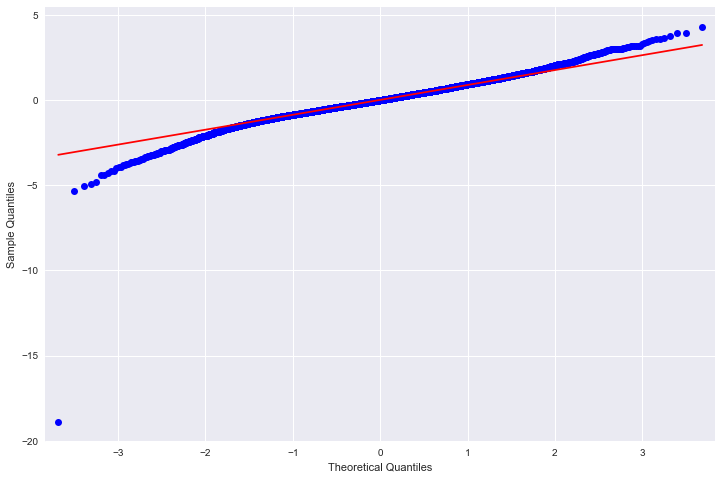

In [18]:
model = sm.tsa.ARIMA(dataset_LT1, order=(5,0,1))
model_fit = model.fit()
resid501 = model_fit.resid
#normality
print(stats.normaltest(resid501))

# show plots
plt.clf()
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
fig = qqplot(resid501, line='q', ax=ax, fit=True)
plt.show()

### Prediction

/Users/poshin/anaconda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


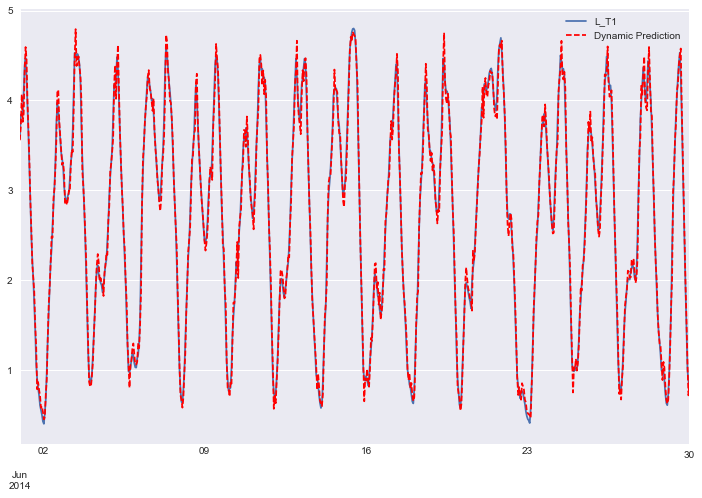

In [19]:
predict_model = model_fit.predict('2014-06-01','2014-06-30', dynamic=False)

#plot predictions and true values
plt.clf()
ax = dataset_LT1.ix['2014-06-01 00:00:00':'2014-06-30 00:00:00'].plot(figsize=(12,8))
ax = predict_model.plot(ax=ax, style='r--', label='Dynamic Prediction');
ax.legend();
plt.show()

### residual in training dataset (dataset 1)

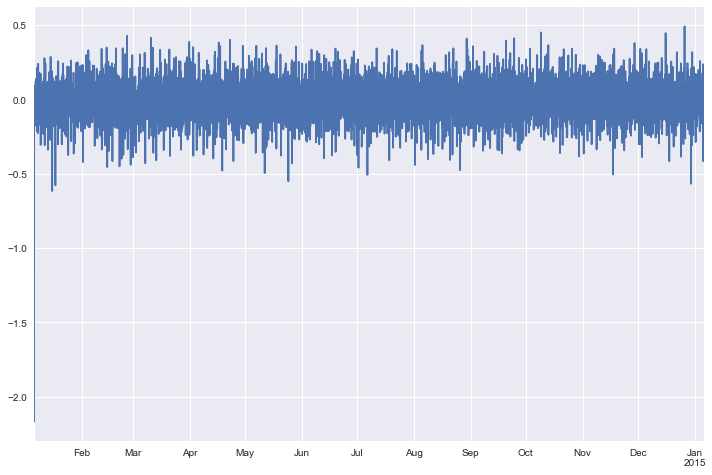

In [287]:
plt.clf()
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax = model_fit.resid.plot(ax=ax);
plt.show()

### Validation dataset

In [20]:
idx_change = ['L_T1', 'L_T2', 'L_T3', 'L_T4', 'L_T5', 'L_T6', 'L_T7',
        'F_PU1', 'S_PU1', 'F_PU2', 'S_PU2', 'F_PU3', 'S_PU3', 'F_PU4', 'S_PU4',
        'F_PU5', 'S_PU5', 'F_PU6', 'S_PU6', 'F_PU7', 'S_PU7', 'F_PU8', 'S_PU8',
        'F_PU9', 'S_PU9', 'F_PU10', 'S_PU10', 'F_PU11', 'S_PU11', 'F_V2',
        'S_V2', 'P_J280', 'P_J269', 'P_J300', 'P_J256', 'P_J289', 'P_J415',
        'P_J302', 'P_J306', 'P_J307', 'P_J317', 'P_J14', 'P_J422', 'ATT_FLAG']

df_optimize = pd.read_csv("BATADAL_dataset_optimize.csv",index_col=0,header=0,parse_dates=[0],date_parser=parser)
del df_optimize.index.name
df_optimize.columns = idx_change
# df_optimize.head()

### Find detected Attacks and assign them into corresponding sensors based on the document

In [23]:
#All attacked data
Attacked = df_optimize.loc[df_optimize['ATT_FLAG']==1]

Attacked_date = []
for date in Attacked.index:
    Attacked_date.append(str(date).split(' ')[0])
Attacked_date = list(set(Attacked_date))
# print(Attacked_date)

LT1_attacked = [Attacked_date[i] for i in [0,9,12,3,8,7]]
print("Dates that L_T1 being attacked:\n",LT1_attacked)
LT4_attacked = [Attacked_date[i] for i in [10,4,5,6,11]]
print("Dates that L_T4 being attacked:\n",LT4_attacked)
LT7_attacked = [Attacked_date[i] for i in [1,2]]
print("Dates that L_T7 being attacked:\n",LT7_attacked)

Dates that L_T1 being attacked:
 ['2016-10-11', '2016-09-14', '2016-10-09', '2016-12-08', '2016-11-27', '2016-10-31']
Dates that L_T4 being attacked:
 ['2016-12-06', '2016-09-15', '2016-12-07', '2016-10-10', '2016-10-30']
Dates that L_T7 being attacked:
 ['2016-11-01', '2016-12-09']


### LT_1 with best model ARIMA(5,0,1), which is the same as ARMA(5,1)

/Users/poshin/anaconda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/poshin/anaconda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


1.9981467036795473


/Users/poshin/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/poshin/anaconda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


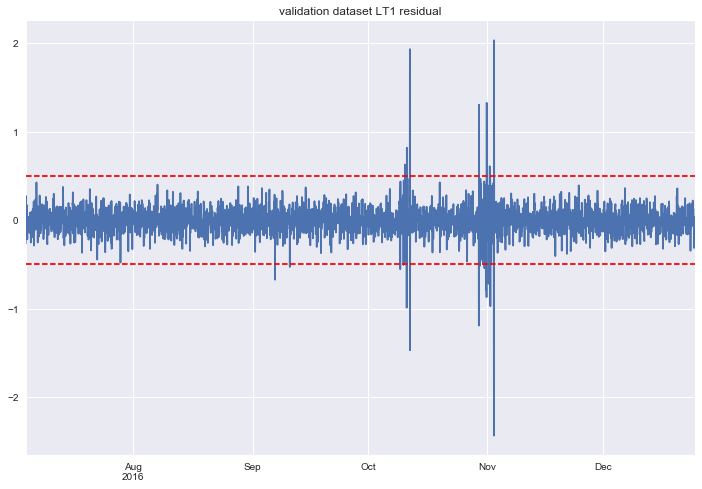

Attacks happend on L_T1 sensor(by date):
 ['2016-10-11', '2016-09-14', '2016-10-09', '2016-12-08', '2016-11-27', '2016-10-31']
Attacks detected on L_T1 sensor:
 ['2016-11-01', '2016-10-11', '2016-09-06', '2016-10-10', '2016-10-31', '2016-10-29', '2016-09-10', '2016-11-02', '2016-10-30', '2016-10-09']
TP:3, FN: 3, FP: 7


In [24]:
Attacked_detected_date = []
df_optimize_LT1 = df_optimize['L_T1']
model = sm.tsa.ARIMA(df_optimize_LT1, order=(5,0,1))
model_fit = model.fit()

#obey the theory or not
print(sm.stats.durbin_watson(model_fit.resid.values))

#residual
resid_LT1 = model_fit.resid


# plot residuals
plt.clf()
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax2 = model_fit.resid.plot(ax=ax);
ax3 = plt.axhline(y= 0.5,color = 'r',linestyle ='--')
ax3 = plt.axhline(y= -0.5,color = 'r',linestyle ='--')
plt.title("validation dataset LT1 residual")
plt.show()

LT1 = pd.concat([resid_LT1.loc[resid_LT1 > 0.5],resid_LT1.loc[resid_LT1 < -0.5]],axis =0)

TP = 0
FP = 0
TN = 0
FN = 0
    
for date in LT1.index:
    Attacked_detected_date.append(str(date).split(' ')[0])

Attacked_detected_date = list(set(Attacked_detected_date))
print("Attacks happend on L_T1 sensor(by date):\n",LT1_attacked)
print("Attacks detected on L_T1 sensor:\n",Attacked_detected_date)
for ind in LT1_attacked:
    if ind in Attacked_detected_date:
        TP += 1
    else:
        FN += 1
for ind in Attacked_detected_date:
    if ind not in LT1_attacked:
        FP += 1
        
print("TP:%d, FN: %d, FP: %d"%(TP,FN,FP))


### L_T4 with best model ARIMA(5,0,2), which is the same as ARMA(5,2)
ARMA in L_T4 cannot perform well

/Users/poshin/anaconda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/poshin/anaconda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


1.9989851163129593


/Users/poshin/anaconda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


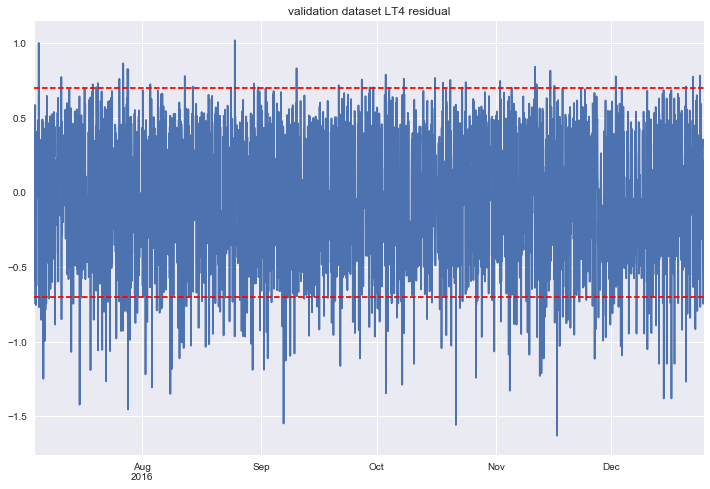

Attacks happend on L_T4 sensor(by date):
 ['2016-11-27', '2016-12-06', '2016-12-09', '2016-12-07', '2016-12-08']
Attacks detected on L_T4 sensor:
 ['2016-10-03', '2016-10-08', '2016-12-02', '2016-08-29', '2016-08-02', '2016-07-25', '2016-11-20', '2016-07-11', '2016-11-29', '2016-09-26', '2016-12-12', '2016-07-13', '2016-08-13', '2016-11-17', '2016-08-26', '2016-10-01', '2016-12-19', '2016-08-18', '2016-08-19', '2016-09-13', '2016-09-16', '2016-08-03', '2016-09-29', '2016-10-24', '2016-12-13', '2016-10-26', '2016-11-05', '2016-08-31', '2016-10-14', '2016-12-10', '2016-11-02', '2016-08-14', '2016-09-14', '2016-11-07', '2016-07-26', '2016-09-07', '2016-12-17', '2016-10-06', '2016-10-20', '2016-07-20', '2016-09-25', '2016-09-08', '2016-09-01', '2016-08-01', '2016-11-18', '2016-12-16', '2016-07-06', '2016-08-24', '2016-09-02', '2016-10-07', '2016-08-05', '2016-07-18', '2016-11-26', '2016-11-12', '2016-09-10', '2016-12-09', '2016-07-05', '2016-11-06', '2016-11-27', '2016-07-15', '2016-10-10'

In [314]:
Attacked_detected_date = []
df_optimize_LT4 = df_optimize['L_T4']
model = sm.tsa.ARIMA(df_optimize_LT4, order=(5,0,2))
model_fit = model.fit()

#obey the theory or not
print(sm.stats.durbin_watson(model_fit.resid.values))

#residual
resid_LT4 = model_fit.resid


# plot residuals
plt.clf()
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax2 = model_fit.resid.plot(ax=ax);
ax3 = plt.axhline(y= 0.7,color = 'r',linestyle ='--')
ax3 = plt.axhline(y= -0.7,color = 'r',linestyle ='--')
plt.title("validation dataset LT4 residual")
plt.show()

LT4 = pd.concat([resid_LT4.loc[resid_LT4 > 0.7],resid_LT4.loc[resid_LT4 < -0.8]],axis =0)

# print(len(resid_attacked),'\n',resid_attacked.index)
# print('\n\n',len(LT1),'\n',LT1.index)

TP = 0
FP = 0
TN = 0
FN = 0
    
for date in LT4.index:
    Attacked_detected_date.append(str(date).split(' ')[0])

Attacked_detected_date = list(set(Attacked_detected_date))
print("Attacks happend on L_T4 sensor(by date):\n",LT4_attacked)
print("Attacks detected on L_T4 sensor:\n",Attacked_detected_date)
for ind in LT4_attacked:
    if ind in Attacked_detected_date:
        TP += 1
    else:
        FN += 1
for ind in Attacked_detected_date:
    if ind not in LT4_attacked:
        FP += 1
        
print("TP:%d, FN: %d, FP: %d"%(TP,FN,FP))



### LT_7 with best model ARIMA(4,0,2), which is the same as ARMA(4,2)
ARMA in L_T7 cannot perform well

/Users/poshin/anaconda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/poshin/anaconda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


1.9970862718295577


/Users/poshin/anaconda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


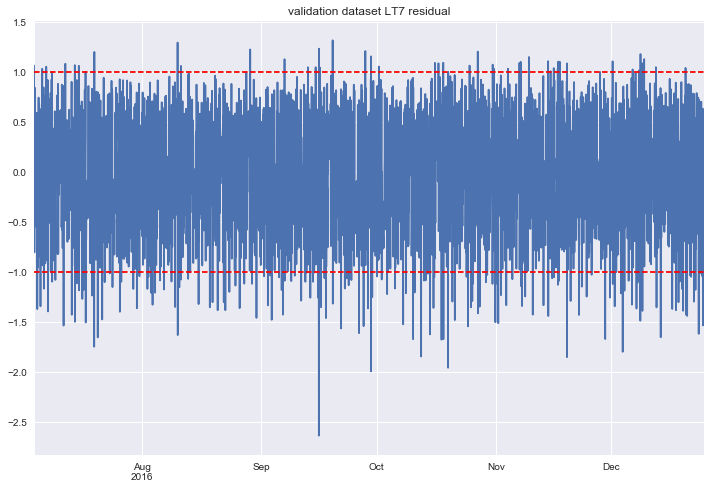

Attacks happend on L_T7 sensor(by date):
 ['2016-11-01', '2016-12-09']
Attacks detected on L_T7 sensor:
 ['2016-11-16', '2016-07-17', '2016-10-16', '2016-08-15', '2016-07-12', '2016-11-14', '2016-09-12', '2016-07-15', '2016-09-05', '2016-10-31', '2016-08-27', '2016-12-20', '2016-09-02', '2016-10-27', '2016-09-24', '2016-09-27', '2016-12-06', '2016-07-31', '2016-10-07', '2016-08-26', '2016-08-03', '2016-07-09', '2016-09-23', '2016-12-08', '2016-08-25', '2016-11-17', '2016-10-10', '2016-10-08', '2016-10-29', '2016-12-18', '2016-09-17', '2016-09-08', '2016-11-19', '2016-07-07', '2016-12-12', '2016-12-19', '2016-09-21', '2016-07-04', '2016-12-22', '2016-07-21', '2016-11-08', '2016-07-05', '2016-09-11', '2016-07-14', '2016-10-24', '2016-08-20', '2016-07-24', '2016-08-08', '2016-09-15', '2016-11-15', '2016-12-03', '2016-12-04', '2016-11-20', '2016-10-05', '2016-11-22', '2016-11-09', '2016-11-13', '2016-11-24', '2016-10-17', '2016-12-01', '2016-09-22', '2016-08-23', '2016-09-14', '2016-09-07'

In [25]:
Attacked_detected_date = []
df_optimize_LT7 = df_optimize['L_T7']
model = sm.tsa.ARIMA(df_optimize_LT7, order=(4,0,2))
model_fit = model.fit()

#obey the theory or not
print(sm.stats.durbin_watson(model_fit.resid.values))

#residual
resid_LT7 = model_fit.resid


# plot residuals
plt.clf()
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax2 = model_fit.resid.plot(ax=ax);
ax3 = plt.axhline(y= 1,color = 'r',linestyle ='--')
ax3 = plt.axhline(y= -1,color = 'r',linestyle ='--')
plt.title("validation dataset LT7 residual")
plt.show()

LT7 = pd.concat([resid_LT7.loc[resid_LT7 > 1],resid_LT7.loc[resid_LT7 < -1]],axis =0)


TP = 0
FP = 0
TN = 0
FN = 0
    
for date in LT7.index:
    Attacked_detected_date.append(str(date).split(' ')[0])

Attacked_detected_date = list(set(Attacked_detected_date))
print("Attacks happend on L_T7 sensor(by date):\n",LT7_attacked)
print("Attacks detected on L_T7 sensor:\n",Attacked_detected_date)
for ind in LT7_attacked:
    if ind in Attacked_detected_date:
        TP += 1
    else:
        FN += 1
for ind in Attacked_detected_date:
    if ind not in LT7_attacked:
        FP += 1
        
print("TP:%d, FN: %d, FP: %d"%(TP,FN,FP))




### Test on dataset 3
#### Test ARMA model in L_T1 sensor, which is the one with the best training performance.
#### In the test set, there's no attack in L_T1 sensor. Thus, it would be nice if the False Positive number is low

In [26]:
def parser(x):
    return pd.datetime.strptime(x,'%d/%m/%y %H')

idx_change = ['L_T1', 'L_T2', 'L_T3', 'L_T4', 'L_T5', 'L_T6', 'L_T7',
        'F_PU1', 'S_PU1', 'F_PU2', 'S_PU2', 'F_PU3', 'S_PU3', 'F_PU4', 'S_PU4',
        'F_PU5', 'S_PU5', 'F_PU6', 'S_PU6', 'F_PU7', 'S_PU7', 'F_PU8', 'S_PU8',
        'F_PU9', 'S_PU9', 'F_PU10', 'S_PU10', 'F_PU11', 'S_PU11', 'F_V2',
        'S_V2', 'P_J280', 'P_J269', 'P_J300', 'P_J256', 'P_J289', 'P_J415',
        'P_J302', 'P_J306', 'P_J307', 'P_J317', 'P_J14', 'P_J422']

df_test = pd.read_csv("BATADAL_test_dataset.csv",index_col=0,header=0,parse_dates=[0],date_parser=parser)
del df_test.index.name

df_test.columns = idx_change
# df_test.head()

/Users/poshin/anaconda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/poshin/anaconda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/Users/poshin/anaconda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


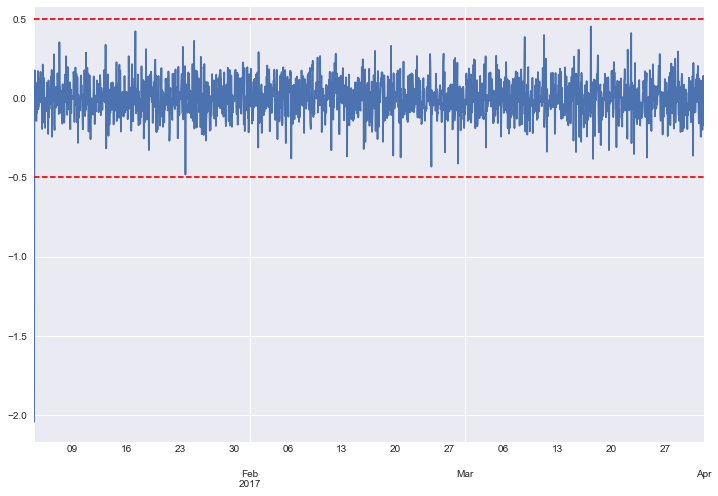

Attacks detected on L_T1 sensor:
 ['2017-01-04']


In [27]:
Attacked_detected_date = []
df_test_LT1 = df_test['L_T1']
model = sm.tsa.ARIMA(df_test_LT1, order=(5,0,1))
model_fit = model.fit()

#residual
resid_LT1 = model_fit.resid

# plot residuals
plt.clf()
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax2 = model_fit.resid.plot(ax=ax);
ax3 = plt.axhline(y= 0.5,color = 'r',linestyle ='--')
ax3 = plt.axhline(y= -0.5,color = 'r',linestyle ='--')
# plt.title("validation dataset LT1 residual")
plt.show()

LT1 = pd.concat([resid_LT1.loc[resid_LT1 > 0.5],resid_LT1.loc[resid_LT1 < -0.5]],axis =0)


TP = 0
FP = 0
TN = 0
FN = 0
    
for date in LT1.index:
    Attacked_detected_date.append(str(date).split(' ')[0])

print("Attacks detected on L_T1 sensor:\n",Attacked_detected_date)



# End

In [31]:
# df_optimize_LT = df_optimize['L_T4']
# model = sm.tsa.ARIMA(df_optimize_LT, order=(5,0,2))
# model_fit = model.fit()

# #obey the theory or not
# print(sm.stats.durbin_watson(model_fit.resid.values))
# # print(model_fit.resid)

# #residual
# resid_LT = model_fit.resid
# #Attacked
# resid_attacked = df_optimize_LT.loc[df_optimize['ATT_FLAG']==1]


# # show plots in the notebook
# plt.clf()
# fig = plt.figure(figsize=(12,8))
# ax = fig.add_subplot(111)
# ax2 = model_fit.resid.plot(ax=ax);
# plt.title("validation dataset LT4 residual")
# plt.show()

# print(len(resid_attacked),'\n',resid_attacked.index)

# LT = pd.concat([resid_LT.loc[resid_LT > 0.5],resid_LT.loc[resid_LT < -0.5]],axis =0)
# print('\n\n',len(LT),'\n',LT.index)

# count = 0
# for ind in LT.index:
#     if ind in resid_attacked.index:
#         count += 1
# print(count)

In [30]:
# df_optimize_LT = df_optimize['L_T5']
# model = sm.tsa.ARIMA(df_optimize_LT, order=(5,0,2))
# model_fit = model.fit()

# #obey the theory or not
# print(sm.stats.durbin_watson(model_fit.resid.values))
# # print(model_fit.resid)

# #residual
# resid_LT = model_fit.resid
# #Attacked
# resid_attacked = df_optimize_LT.loc[df_optimize['ATT_FLAG']==1]


# # show plots in the notebook
# plt.clf()
# fig = plt.figure(figsize=(12,8))
# ax = fig.add_subplot(111)
# ax2 = model_fit.resid.plot(ax=ax);
# plt.title("validation dataset LT5 residual")
# plt.show()

# print(len(resid_attacked),'\n',resid_attacked.index)

# LT = pd.concat([resid_LT.loc[resid_LT > 0.5],resid_LT.loc[resid_LT < -0.5]],axis =0)
# print('\n\n',len(LT),'\n',LT.index)

# count = 0
# for ind in LT.index:
#     if ind in resid_attacked.index:
#         count += 1
# print(count)

In [29]:
# df_optimize_LT = df_optimize['L_T6']
# model = sm.tsa.ARIMA(df_optimize_LT, order=(5,0,2))
# model_fit = model.fit()

# #obey the theory or not
# print(sm.stats.durbin_watson(model_fit.resid.values))
# # print(model_fit.resid)

# #residual
# resid_LT = model_fit.resid
# #Attacked
# resid_attacked = df_optimize_LT.loc[df_optimize['ATT_FLAG']==1]


# # show plots in the notebook
# plt.clf()
# fig = plt.figure(figsize=(12,8))
# ax = fig.add_subplot(111)
# ax2 = model_fit.resid.plot(ax=ax);
# plt.title("validation dataset LT6 residual")
# plt.show()

# print(len(resid_attacked),'\n',resid_attacked.index)

# LT = pd.concat([resid_LT.loc[resid_LT > 0.5],resid_LT.loc[resid_LT < -0.5]],axis =0)
# print('\n\n',len(LT),'\n',LT.index)

# count = 0
# for ind in LT.index:
#     if ind in resid_attacked.index:
#         count += 1
# print(count)

In [28]:
# df_optimize_LT = df_optimize['L_T7']
# model = sm.tsa.ARIMA(df_optimize_LT, order=(2,0,2))
# model_fit = model.fit()

# #obey the theory or not
# print(sm.stats.durbin_watson(model_fit.resid.values))
# # print(model_fit.resid)

# #residual
# resid_LT = model_fit.resid
# #Attacked
# resid_attacked = df_optimize_LT.loc[df_optimize['ATT_FLAG']==1]


# # show plots in the notebook
# plt.clf()
# fig = plt.figure(figsize=(12,8))
# ax = fig.add_subplot(111)
# ax2 = model_fit.resid.plot(ax=ax);
# plt.title("validation dataset LT7 residual")
# plt.show()

# print(len(resid_attacked),'\n',resid_attacked.index)

# LT = pd.concat([resid_LT.loc[resid_LT > 0.5],resid_LT.loc[resid_LT < -0.5]],axis =0)
# print('\n\n',len(LT),'\n',LT.index)

# count = 0
# for ind in LT.index:
#     if ind in resid_attacked.index:
#         count += 1
# print(count)